# Линейный Энкодер-Декодер

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
plt.style.use('seaborn')

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path
from skimage import transform
from sklearn.metrics import roc_auc_score, f1_score
from functions import *
from functions import good_cols, SignalDataset
%matplotlib inline

C:\Users\kitro\anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [2]:
all_df = get_df()

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:18<00:00,  2.06s/it]


### Выбираем длину

In [3]:
TARGET_LEN = 10000
activities = sep_by_len(all_df, TARGET_LEN)
activities.shape

(83, 32)

In [4]:
CUT_LEN = 100
cut_df = cut_act(activities, CUT_LEN, count=50, random_start=True)
cut_df.sample()

100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [00:11<00:00,  7.31it/s]


,activityID,heart rate,temperature hand,3Da_x scale_16 hand,3Da_y scale_16 hand,3Da_z scale_16 hand,3Dg_x hand,3Dg_y hand,3Dg_z hand,3Dm_x hand,...,temperature ankle,3Da_x scale_16 ankle,3Da_y scale_16 ankle,3Da_z scale_16 ankle,3Dg_x ankle,3Dg_y ankle,3Dg_z ankle,3Dm_x ankle,3Dm_y ankle,3Dm_z ankle
3923,12,"[120.0, 120.0, 120.0, 120.0, 120.0, 120.0, 120...","[34.3125, 34.3125, 34.3125, 34.3125, 34.3125, ...","[-13.3366, -13.9453, -14.5012, -15.0015, -15.0...","[-0.564673, -0.750371, -0.516011, -0.665987, -...","[0.0731511, -0.0123141, 0.24798, 0.0100672, -0...","[-0.263018, 0.218673, 0.794952, 1.26126, 1.649...","[3.24489, 3.27395, 3.21824, 3.16317, 3.02002, ...","[2.97852, 3.05594, 3.12266, 3.16207, 3.09149, ...","[23.2748, 25.1497, 26.5222, 28.9119, 29.6415, ...",...,"[34.25, 34.25, 34.25, 34.25, 34.25, 34.25, 34....","[14.7917, 17.7312, 19.7234, 21.5868, 25.4828, ...","[-4.46089, 0.675587, 2.10551, -6.36849, 0.0215...","[-4.58332, -3.50455, -3.4544, -8.66947, -8.399...","[1.51788, 0.60993, -0.655141, -2.45187, -3.991...","[0.305421, 0.521992, 0.889844, 1.02335, 0.6872...","[0.193194, 1.08062, 1.99924, 2.85991, 3.46163,...","[-30.011, -30.6793, -30.1734, -29.257, -29.111...","[23.0946, 24.6737, 25.0355, 24.0894, 23.9576, ...","[41.4144, 41.6939, 41.9789, 42.2669, 43.6859, ..."


### Получаем признаки

In [94]:
X = cut_df.iloc[:, 1:].values

Y = cut_df.iloc[:, 0] # целевая переменная
X.shape, Y.shape

((4150, 31), (4150,))

In [95]:
y_targ = y_encode(Y)
np.unique(y_targ)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

### Нормализация

In [96]:
X_norm = normalize_dif_len(X)
X_norm.shape

(100, 4150, 31)

### Приводим к одной длине

In [97]:
X_eq = np.transpose(np.array(X_norm,dtype=np.float64), axes = [1,0,2])
X_eq.shape

(4150, 100, 31)

In [98]:
X_flat = get_flatten(X_eq)
X_flat.shape

(4150, 3100)

In [99]:
X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = \
    train_test_split(torch.FloatTensor(X_flat), torch.LongTensor(y_targ), random_state=42, test_size = 0.2)
X_train_tensor.shape, y_train_tensor.shape, np.unique(y_train_tensor), np.unique(y_val_tensor)

(torch.Size([3320, 3100]),
 torch.Size([3320]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64))

In [100]:
BATCH_SIZE = 64

trainset = SignalDataset(X_train_tensor, y_train_tensor)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=0)

testset = SignalDataset(X_val_tensor, y_val_tensor)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=0)
len(trainset)

3320

## Подготовка модели

In [101]:
torch.min(X_train_tensor), torch.max(X_train_tensor)

(tensor(-39.1376), tensor(74.4165))

In [102]:
activation = nn.LeakyReLU

class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 4096),
            activation(),
            nn.Linear(4096, 512),
            activation(),
            nn.Linear(512, 128),
            activation(),
            nn.Linear(128, 32),
            activation(),
            nn.Linear(32, 4),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(4, 32),
            activation(),
            nn.Linear(32, 128),
            activation(),
            nn.Linear(128, 512),
            activation(),
            nn.Linear(512, 4096),
            activation(),
            nn.Linear(4096, input_size),
            
        )
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return dec

net = Autoencoder(X_train_tensor.shape[1])

## Обучение

In [103]:
NUM_EPOCHS = 10

loss_fn = torch.nn.MSELoss()
losses = []
val_losses = []

learning_rate = 3e-3
optimizer = torch.optim.AdamW(net.parameters(), lr=learning_rate)
ebar = tqdm(range(NUM_EPOCHS))

for epoch_num in ebar:
    running_loss = 0.0
    iter_num = 0
#     pbar = tqdm(enumerate(trainloader), total = len(trainloader))
    pbar = enumerate(trainloader)
    for iter_num, (X_batch, y_batch) in pbar:
        iter_num +=1
        
        recon = net(X_batch)
        
        loss = loss_fn(recon, X_batch)
        running_loss += loss.item()
                     
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    line = '[{}/{}] current loss: {}'.format(epoch_num+1, NUM_EPOCHS, running_loss/len(trainset))
    ebar.set_description(line)
    
    losses.append(running_loss/len(trainset))
        
    with torch.no_grad():
        recon = net(X_val_tensor)
        score = loss_fn(recon, X_val_tensor)
#         line = '[{}/{}] current valid score: {}'.format(epoch_num+1, NUM_EPOCHS, f1_score(y_val_tensor, y, average='macro'))
#         print(line)
        val_losses.append(score)

[10/10] current loss: 0.008499488683350116: 100%|██████████████████████████████████████| 10/10 [02:00<00:00, 12.05s/it]


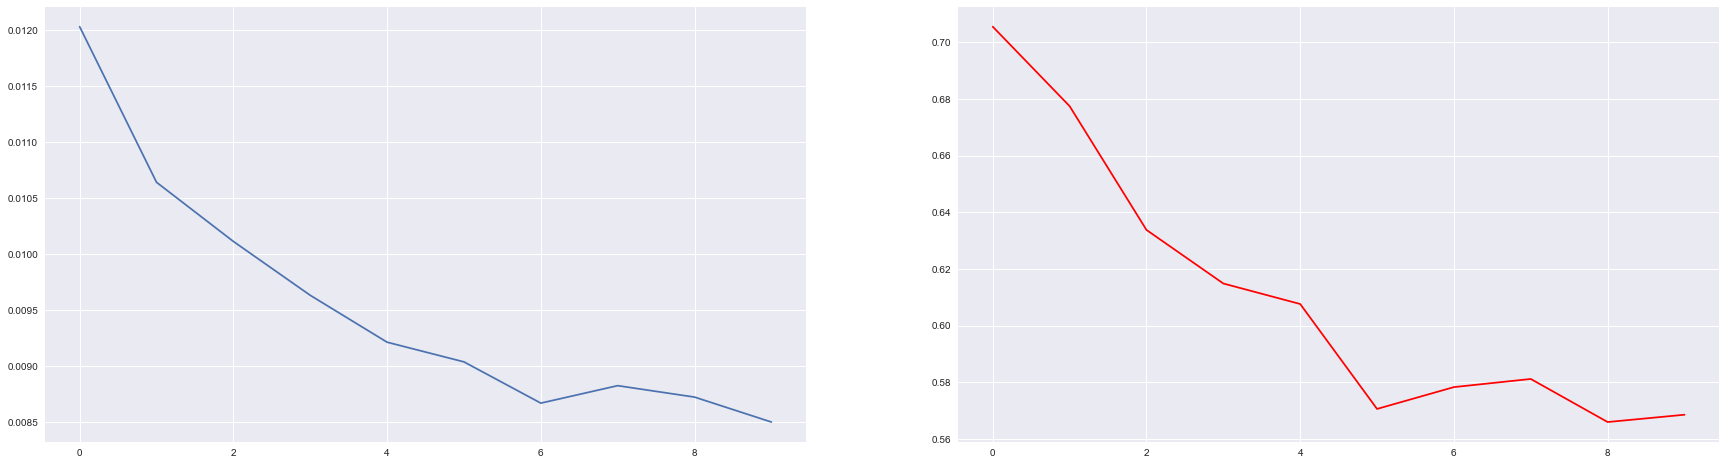

In [104]:
fig, axs = plt.subplots(1,2,figsize=(30,8))
axs[0].plot(np.arange(NUM_EPOCHS), losses)
axs[1].plot(np.arange(NUM_EPOCHS), val_losses, color='red')
plt.show()

### Оценка точности

In [91]:
recon = net(X_val_tensor)
a = np.reshape(recon.detach().numpy(),(-1, CUT_LEN, 31))
b = np.reshape(X_val_tensor.detach().numpy(),(-1, CUT_LEN, 31))

r = np.random.randint(0, len(a))
a[r, :5, :5], b[r, :5, :5], r

(array([[-0.0276061 ,  0.7536838 ,  0.1370657 ,  0.2244466 ,  0.30526933],
        [-0.14929423,  0.75693357,  0.24678905,  0.31539115,  0.34234518],
        [ 0.04000431,  0.8789592 ,  0.15777595,  0.04207595,  0.24487248],
        [ 0.16523504,  0.84577733,  0.43686298,  0.33113182,  0.39993882],
        [-0.16242136,  0.8127325 ,  0.3193886 ,  0.19105776,  0.27872184]],
       dtype=float32),
 array([[-0.03816651,  0.95195204, -0.1482668 ,  0.03840995, -0.06806673],
        [-0.03816651,  0.95195204, -0.10803133,  0.04078386, -0.04128432],
        [-0.03816651,  0.95195204, -0.13968974, -0.00314623, -0.19872515],
        [-0.03816651,  0.95195204, -0.11930297, -0.02785331, -0.11431916],
        [-0.03816651,  0.95195204, -0.07849827, -0.03861342, -0.18087775]],
       dtype=float32),
 134)

# Только 1 параметр

#### Если нужны параметры

In [3]:
good_cols

['activityID',
 'heart rate',
 'temperature hand',
 '3Da_x scale_16 hand',
 '3Da_y scale_16 hand',
 '3Da_z scale_16 hand',
 '3Dg_x hand',
 '3Dg_y hand',
 '3Dg_z hand',
 '3Dm_x hand',
 '3Dm_y hand',
 '3Dm_z hand',
 'temperature chest',
 '3Da_x scale_16 chest',
 '3Da_y scale_16 chest',
 '3Da_z scale_16 chest',
 '3Dg_x chest',
 '3Dg_y chest',
 '3Dg_z chest',
 '3Dm_x chest',
 '3Dm_y chest',
 '3Dm_z chest',
 'temperature ankle',
 '3Da_x scale_16 ankle',
 '3Da_y scale_16 ankle',
 '3Da_z scale_16 ankle',
 '3Dg_x ankle',
 '3Dg_y ankle',
 '3Dg_z ankle',
 '3Dm_x ankle',
 '3Dm_y ankle',
 '3Dm_z ankle']

In [4]:
CUT_LEN = 200
COUNT = 20
TARGET_LEN = COUNT*CUT_LEN
need_param = '3Da_y scale_16 chest'

X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor, x_mean, x_var = \
get_tensors_1param(all_df, TARGET_LEN, CUT_LEN, COUNT, need_param, random_state=42, test_size=0.2, random_start=True, get_mean=True)
X_train_tensor.shape, y_train_tensor.shape, np.unique(y_train_tensor), np.unique(y_val_tensor)

100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [00:02<00:00, 29.56it/s]


(torch.Size([1408, 200]),
 torch.Size([1408]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64))

In [5]:
torch.min(X_train_tensor), torch.max(X_train_tensor)

(tensor(-1.8142), tensor(4.8037))

In [6]:
BATCH_SIZE = 64

trainset = SignalDataset(X_train_tensor, y_train_tensor)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=0)

testset = SignalDataset(X_val_tensor, y_val_tensor)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=0)
len(trainset)

1408

## Подготовка модели

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, activation):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 4096),
            activation(),
            nn.Linear(4096, 512),
            activation(),
            nn.Linear(512, 128),
            activation(),
            nn.Linear(128, 16),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(16, 128),
            activation(),
            nn.Linear(128, 512),
            activation(),
            nn.Linear(512, 4096),
            activation(),
            nn.Linear(4096, input_size),
            
        )
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return dec

net_1param = Autoencoder(CUT_LEN, activation=nn.LeakyReLU)

## Обучение

In [8]:
NUM_EPOCHS = 30

loss_fn = torch.nn.MSELoss()
losses = []
val_losses = []

learning_rate = 3e-4
optimizer = torch.optim.AdamW(net_1param.parameters(), lr=learning_rate)
ebar = tqdm(range(NUM_EPOCHS))

for epoch_num in ebar:
    running_loss = 0.0
    iter_num = 0
#     pbar = tqdm(enumerate(trainloader), total = len(trainloader))
    pbar = enumerate(trainloader)
    for iter_num, (X_batch, y_batch) in pbar:
        iter_num +=1
        
        recon = net_1param(X_batch)
        
        loss = loss_fn(recon, X_batch)
        running_loss += loss.item()
                     
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    line = '[{}/{}] current loss: {}'.format(epoch_num+1, NUM_EPOCHS, running_loss/len(trainset))
    ebar.set_description(line)
    
    losses.append(running_loss/len(trainset))
        
    with torch.no_grad():
        recon = net_1param(X_val_tensor)
        score = loss_fn(recon, X_val_tensor)
#         line = '[{}/{}] current valid score: {}'.format(epoch_num+1, NUM_EPOCHS, f1_score(y_val_tensor, y, average='macro'))
#         print(line)
        val_losses.append(score)

[30/30] current loss: 6.422490630277686e-05: 100%|█████████████████████████████████████| 30/30 [00:37<00:00,  1.25s/it]


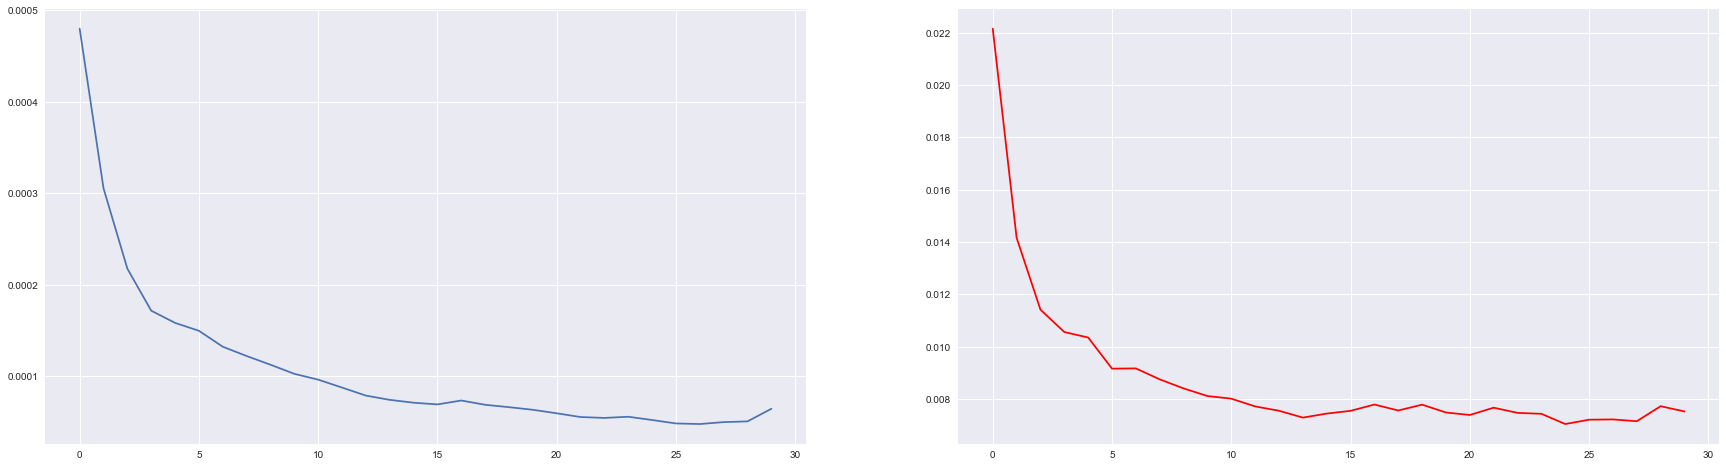

In [9]:
fig, axs = plt.subplots(1,2,figsize=(30,8))
axs[0].plot(np.arange(NUM_EPOCHS), losses)
axs[1].plot(np.arange(NUM_EPOCHS), val_losses, color='red')
plt.show()

## Проверка того что получилось

### Тест базовых сигналов

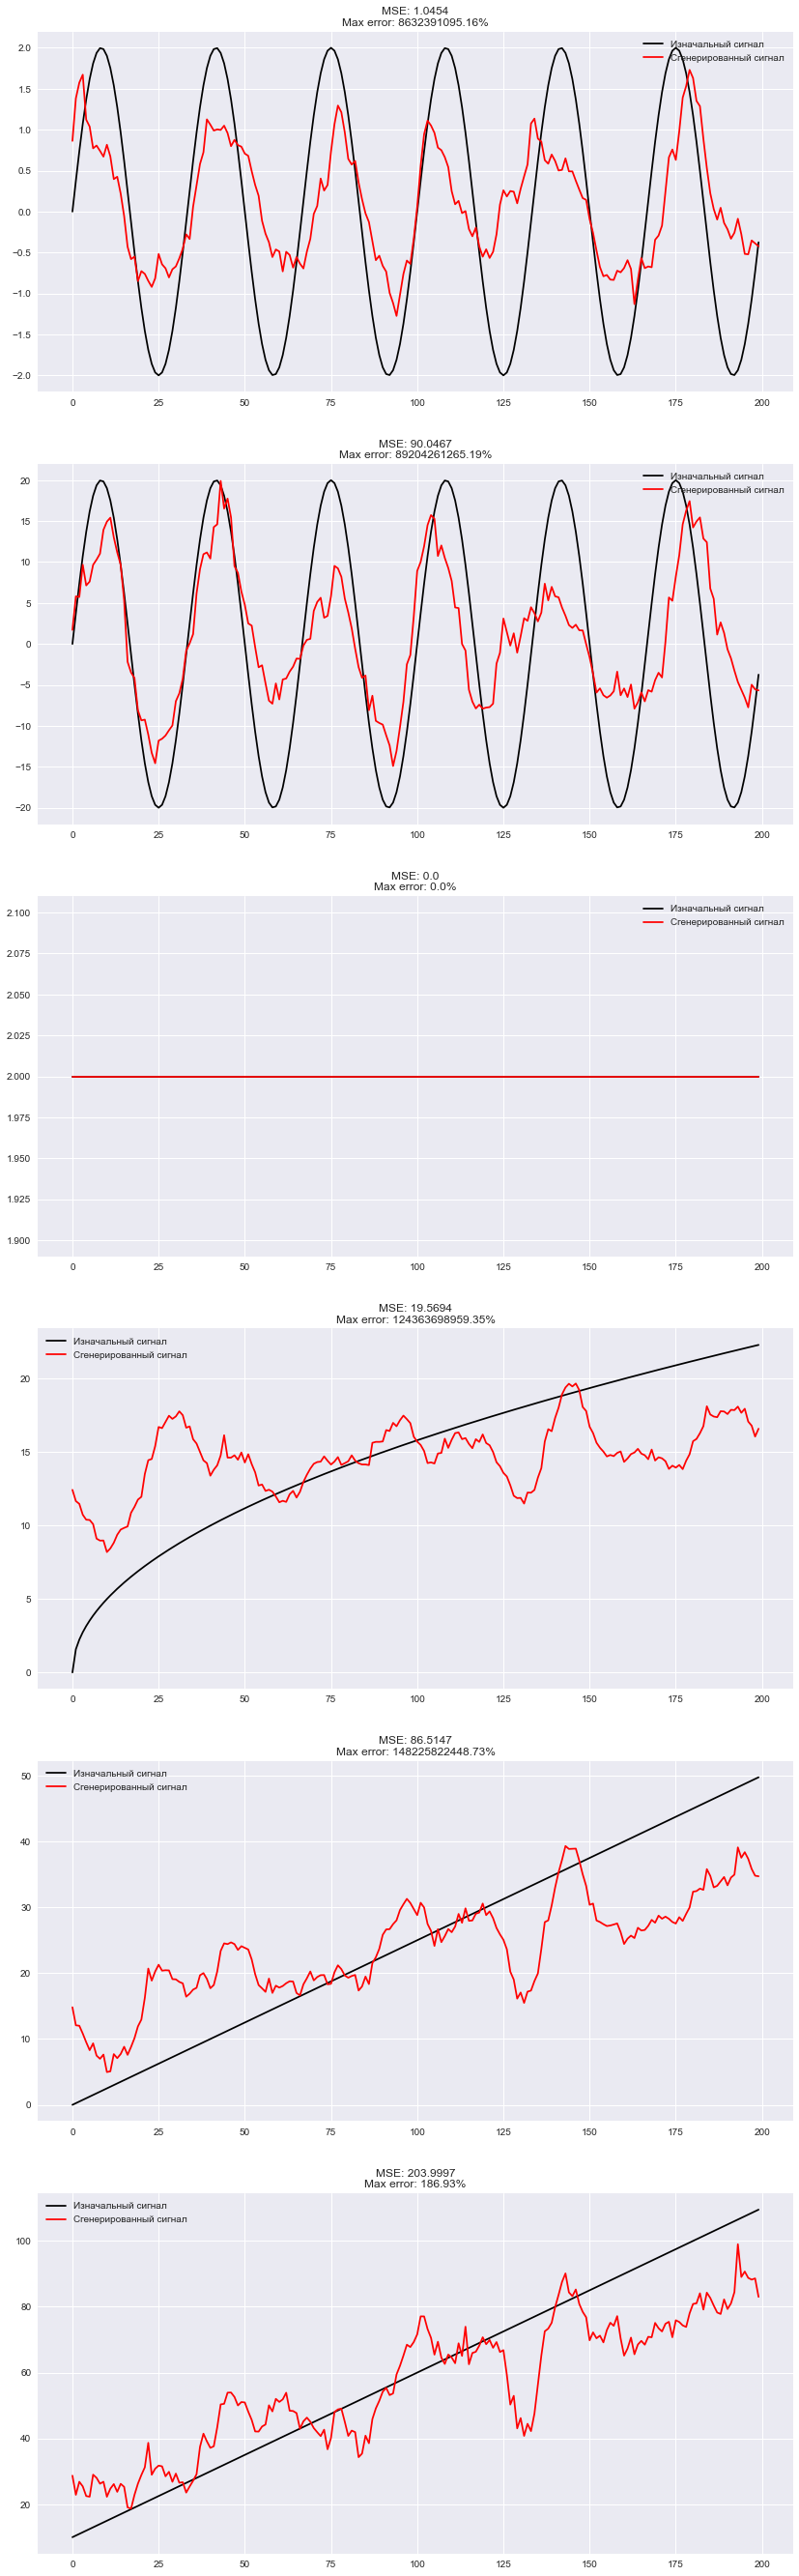

In [11]:
basic_func_check(net_1param, CUT_LEN)

### Тест на обучающей выборке

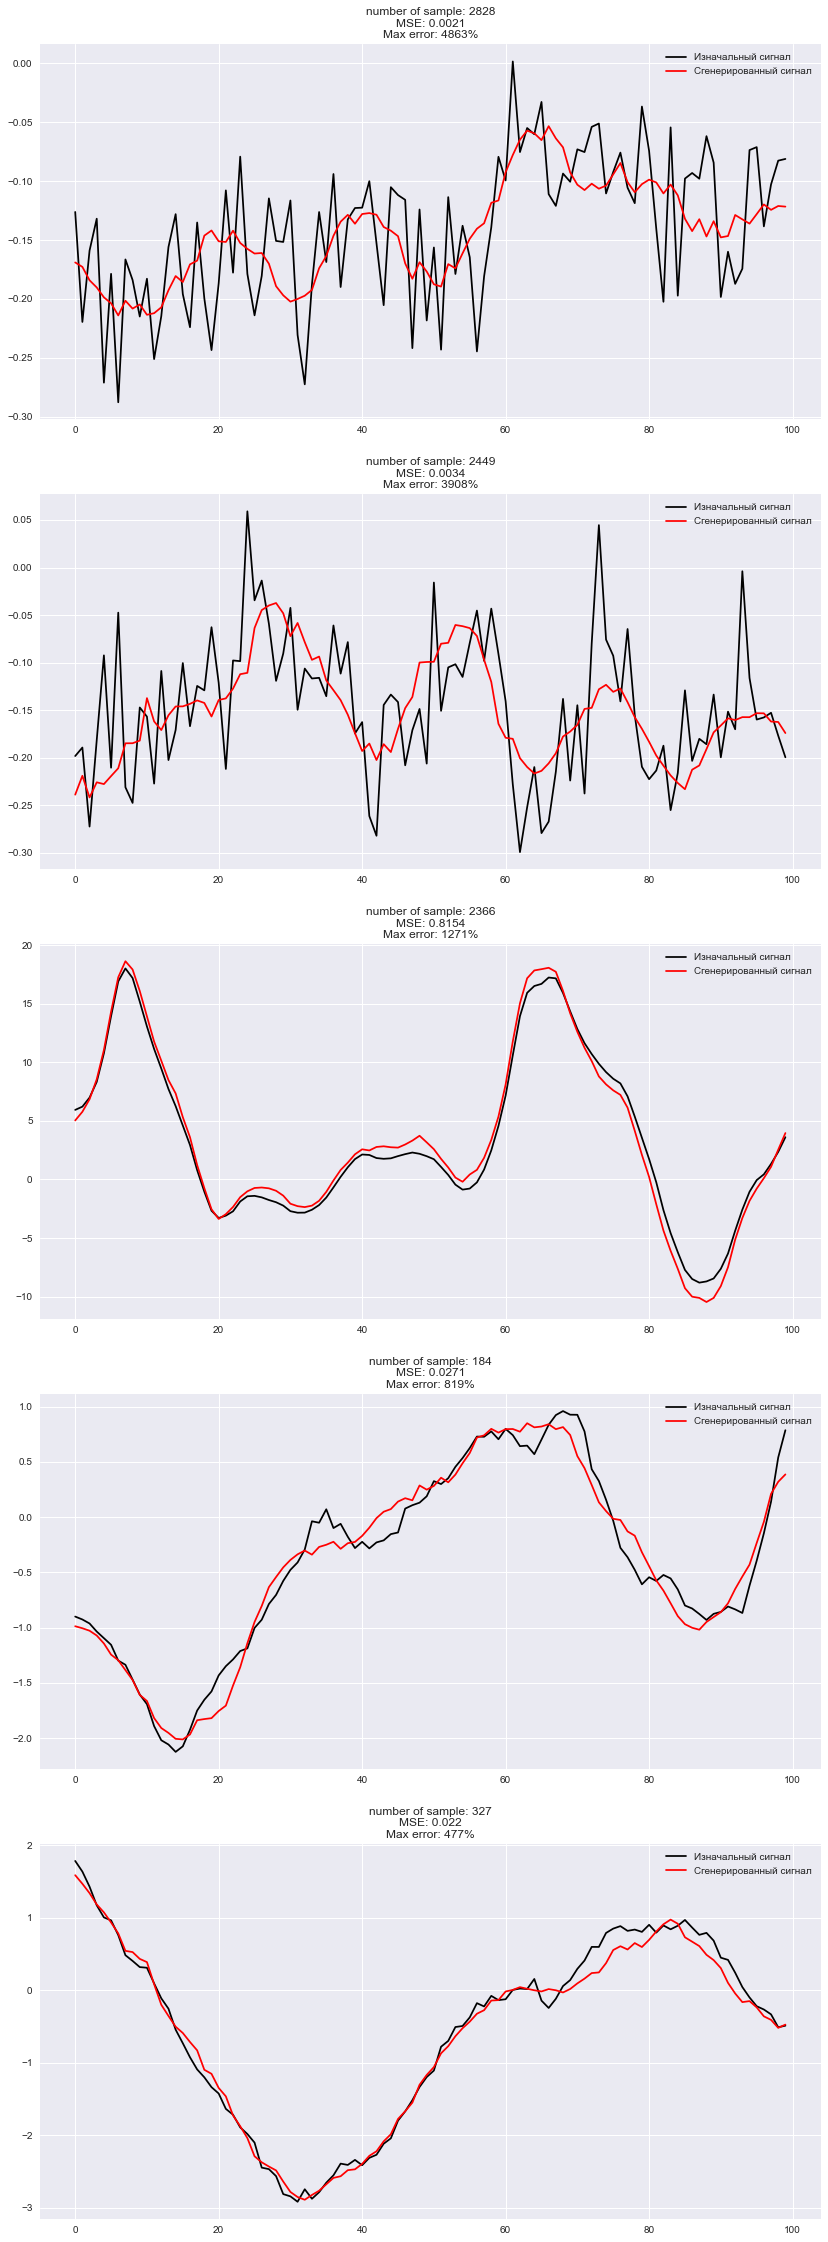

In [230]:
N = 5
tensor_check(net_1param, X_train_tensor, N, x_mean, x_var, without_unnorm=False)

### Тест на валидационной выборке

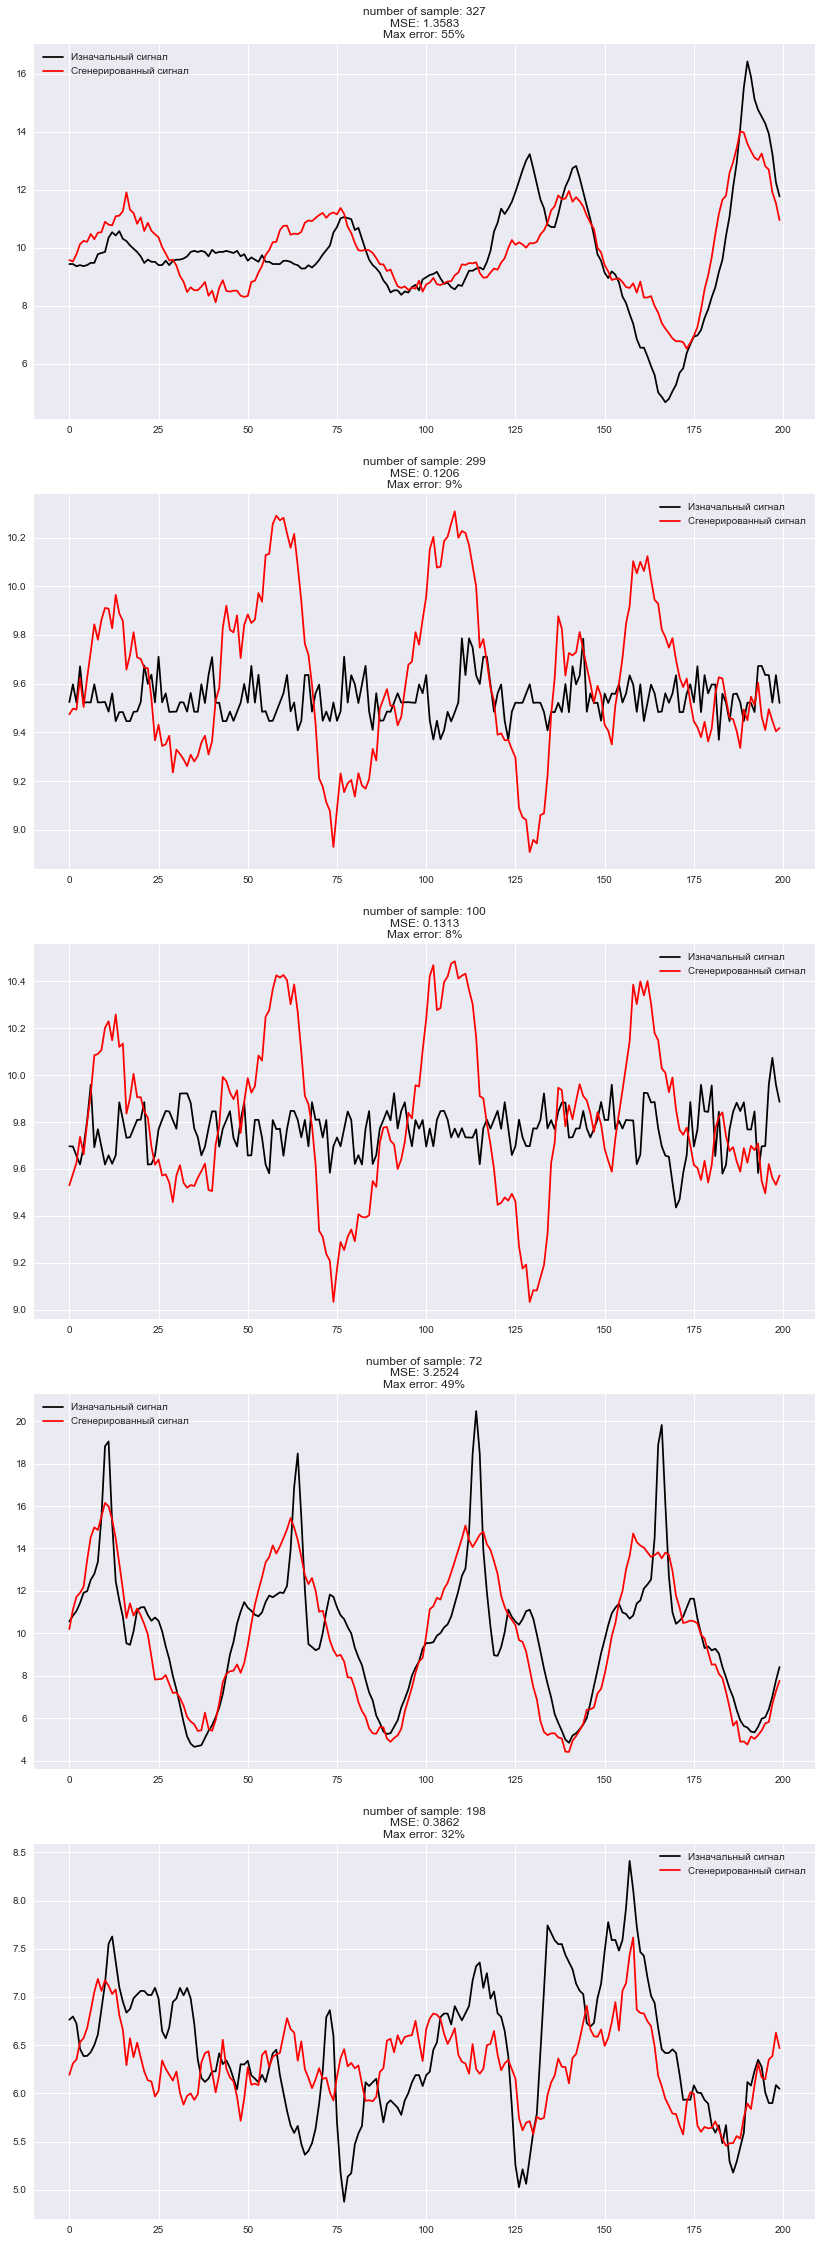

In [12]:
N = 5
tensor_check(net_1param, X_val_tensor, N, x_mean, x_var, without_unnorm=False)

### Другое

In [13]:
need_param = '3Da_x scale_16 chest' # тест по другой оси

ntt, nvt, a, b, x_mean, x_var = \
get_tensors_1param(all_df, TARGET_LEN, CUT_LEN, COUNT, need_param, random_state=42, test_size=0.2, random_start=True, get_mean=True)


100%|██████████████████████████████████████████████████████████████████████████████████| 88/88 [00:02<00:00, 29.91it/s]


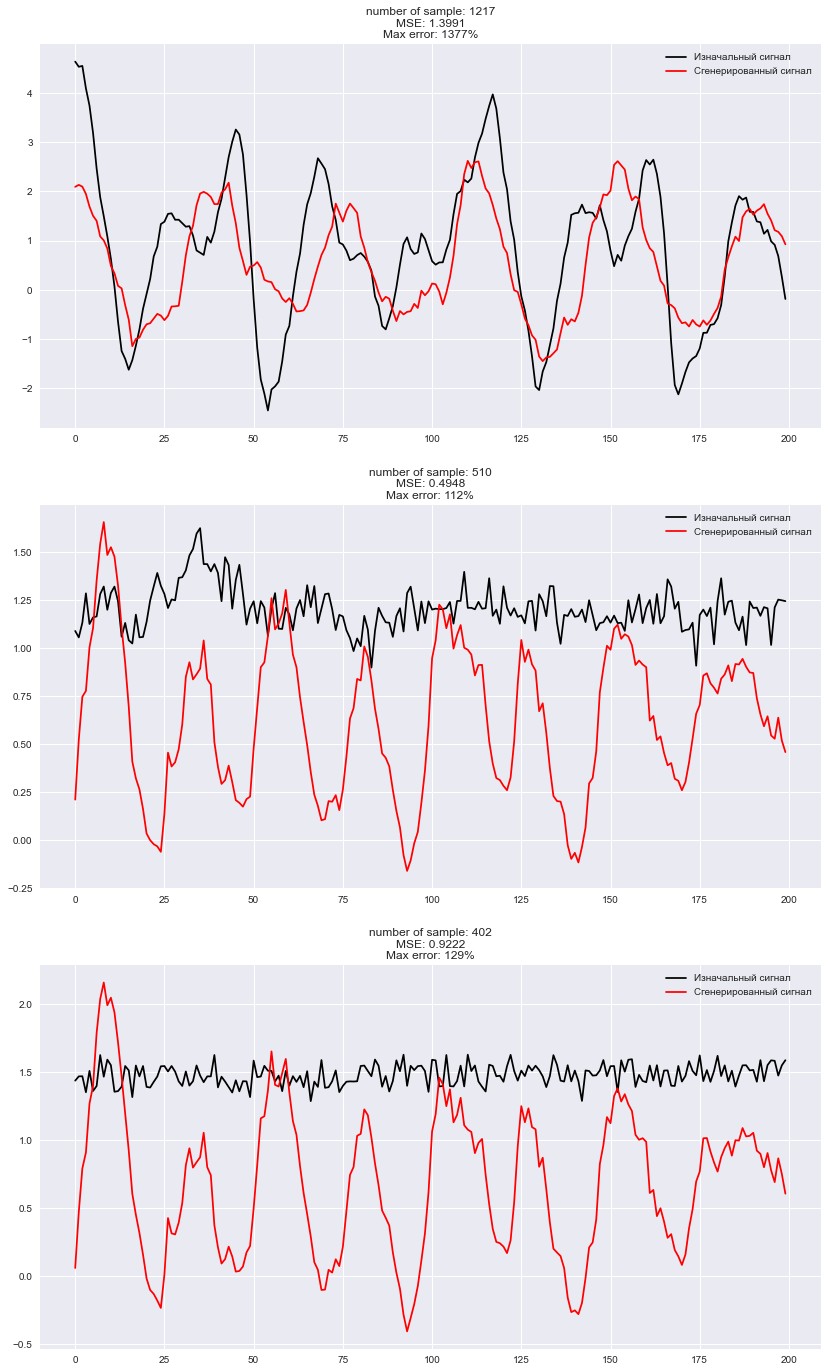

In [14]:
N = 3
tensor_check(net_1param, ntt, N, x_mean, x_var, without_unnorm=False)